# Installation and Repository cloning

In [2]:
!pip install adversarial-robustness-toolbox -U
!pip install multiprocess
!pip install importlib-metadata
!pip install advertorch
!pip install torch torchvision torchaudio
!pip install git+https://github.com/RobustBench/robustbench.git
!pip install numba
!pip install matplotlib
!pip install pillow

  Running command git clone --filter=blob:none --quiet https://github.com/RobustBench/robustbench.git 'C:\Users\Georg Siedel\AppData\Local\Temp\pip-req-build-2m1gaxsl'



  Cloning https://github.com/RobustBench/robustbench.git to c:\users\georg siedel\appdata\local\temp\pip-req-build-2m1gaxsl
  Resolved https://github.com/RobustBench/robustbench.git to commit 776bc95bb4167827fb102a32ac5aea62e46cfaab
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached autoattack-0.1-py3-none-any.whl


## Import Libraries

In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models

import numba
numba.__version__

import importlib
import time
import matplotlib.pyplot as plt
import numpy as np

from art.estimators.classification import PyTorchClassifier
from PIL import Image, ImageDraw, ImageFont, ImageOps
import json

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load and Prepare CIFAR-10 Dataset

In [5]:
def load_dataset(dataset_split):
    # Load CIFAR-10 dataset using torchvision
    transform = transforms.Compose([
      transforms.ToTensor(),
                                 ])
    testset = datasets.CIFAR10(root='./data/cifar', train=False, download=True, transform=transform)

    # Truncated testset for experiments and ablations
    if isinstance(dataset_split, int):
        testset, _ = torch.utils.data.random_split(testset,
                                                          [dataset_split, len(testset) - dataset_split],
                                                          generator=torch.Generator().manual_seed(42))
    
    # Extract data and labels from torchvision dataset
    xtest = torch.stack([data[0] for data in testset])
    ytest = torch.tensor([data[1] for data in testset])

    return xtest, ytest

## Load and Prepare WideResNet Model

In [7]:
#%cd /kaggle/working/adversarial-distance-estimation
from robustbench.utils import load_model

model_name = 'Sehwag2021Proxy_R18'
net = load_model(model_name=model_name, dataset='cifar10', threat_model='L2')
net = torch.nn.DataParallel(net)

%cd
net.eval()

Downloading...
From (original): https://drive.google.com/uc?id=1zPjjZj9wujBNkAmHHHIikem6_aIjMhXG
From (redirected): https://drive.google.com/uc?id=1zPjjZj9wujBNkAmHHHIikem6_aIjMhXG&confirm=t&uuid=5f2ae27d-48a4-4d6f-a21c-7f5ce4f70342
To: c:\Users\Georg Siedel\Documents\Python\elastic_net_adversarial_attack\models\cifar10\L2\Sehwag2021Proxy_R18.pt
100%|██████████| 44.8M/44.8M [00:06<00:00, 6.74MB/s]
c:\Users\Georg Siedel\Documents\Python\elastic_net_adversarial_attack\.venv\Lib\site-packages\robustbench\utils.py:165: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed

C:\Users\Georg Siedel


c:\Users\Georg Siedel\Documents\Python\elastic_net_adversarial_attack\.venv\Lib\site-packages\IPython\core\magics\osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
c:\Users\Georg Siedel\Documents\Python\elastic_net_adversarial_attack\.venv\Lib\site-packages\IPython\core\magics\osm.py:428: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       

## Function to Test Model Accuracy

In [8]:
def test_accuracy(model, xtest, ytest):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for i in range(len(xtest)):
            x = xtest[i].unsqueeze(0).to(device)
            y = ytest[i].unsqueeze(0).to(device)

            outputs = model(x)
            _, predicted = torch.max(outputs.data, 1)

            total += y.size(0)
            correct += (predicted==y).sum().item()

    accuracy = (correct / total) * 100
    print(f'\nAccuracy of the testset is: {accuracy:.3f}%\n')

In [9]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

# Initialize PyTorchClassifier for ART
classifier = PyTorchClassifier(model=net,
                               loss=criterion,
                               optimizer=optimizer,
                               input_shape=(3, 32, 32),
                               nb_classes=10)

In [10]:
from art.attacks.evasion import (FastGradientMethod,
                                 ProjectedGradientDescentNumpy,
                                 AutoAttack,
                                 AutoProjectedGradientDescent,
                                 CarliniL2Method,
                                 CarliniL0Method,
                                 DeepFool,
                                 ElasticNet)

## Adversarial Attack Class

In [ ]:
class AdversarialAttacks:
  def __init__(self, classifier, epsilon, eps_iter, norm, iterations):
    self.classifier = classifier
    self.epsilon = epsilon
    self.eps_iter = eps_iter
    self.norm = norm
    self.iterations = iterations

  def init_attacker(self, attack_type, **kwargs):
    if attack_type=='fast_gradient_method':
        return FastGradientMethod(self.classifier,
                                eps=self.epsilon,
                                eps_step=self.epsilon,
                                norm=self.norm,
                                **kwargs)
    elif attack_type=='projected_gradient_descent':
        return ProjectedGradientDescentNumpy(self.classifier,
                                             eps=self.epsilon,
                                             eps_step=self.eps_iter,
                                             max_iter=self.iterations,
                                             norm=self.norm,
                                             **kwargs)
    elif attack_type=='pgd_early_stopping':
        return ProjectedGradientDescentNumpy(self.classifier,
                                             eps=self.epsilon,
                                             eps_step=self.eps_iter,
                                             max_iter=1,
                                             norm=self.norm,
                                             **kwargs)
    elif attack_type=='auto_attack':
        return AutoAttack(estimator=self.classifier,
                        eps=self.epsilon,
                        eps_step=self.eps_iter,
                        norm=self.norm)
    elif attack_type=='auto_projected_gradient_descent':
        return AutoProjectedGradientDescent(estimator=self.classifier,
                                          eps=self.epsilon,
                                          eps_step=self.eps_iter,
                                          norm=self.norm,
                                          max_iter=self.iterations,
                                          **kwargs)
    elif attack_type=='carlini_wagner_l2':
        return CarliniL2Method(self.classifier,
                               max_iter=self.iterations,
                               **kwargs)
    elif attack_type=='carlini_wagner_l0':
        return CarliniL0Method(self.classifier,
                               max_iter=self.iterations,
                               **kwargs)
    elif attack_type=='deep_fool':
        return DeepFool(self.classifier,
                      max_iter=self.iterations,
                      epsilon=self.eps_iter,
                      **kwargs)
    elif attack_type=='elastic_net':
        return ElasticNet(self.classifier,
                      max_iter=self.iterations)
    else:
        raise ValueError(f'Attack type "{attack_type}" not supported!')

## Plug-in Function for Adversarial Attack with Early Stopping

In [23]:
def attack_with_early_stopping(classifier, x, y, max_iterations, attacker):
    label_flipped = False
    count = 0
    start_time = time.time()

    x = x.unsqueeze(0)

    outputs = classifier.predict(x.cpu().numpy())
    _, clean_predicted = torch.max(torch.tensor(outputs).to(device).data, 1)
    
    if int(clean_predicted.item()) != int(y.item()):
        print('Misclassified input. Not attacking.')
        end_time = time.time()
        return x.cpu().detach().numpy(), end_time - start_time

    for j in range(max_iterations):
        adv_inputs = attacker.generate(x.cpu().detach().numpy(), y.cpu().detach().numpy())

        adv_inputs_tensor = torch.from_numpy(adv_inputs).to(device)
        outputs = classifier.predict(adv_inputs)
        _, predicted = torch.max(torch.tensor(outputs).to(device).data, 1)

        label_flipped = bool(predicted.item() != int(y.item()))

        if label_flipped:
            print(f'\tIterations for successful iterative attack: {j+1}')
            break
            
        x = adv_inputs_tensor.clone()

    end_time = time.time()
    return adv_inputs, end_time - start_time

## Function for Adversarial Distance calculation (attack methods)

In [24]:
def calculation(classifier, xtest, ytest, epsilon, eps_iter, norm, max_iterations, attack_type, get_image: bool = False, verbose: bool = True):

    distance_list, runtime_list = [], []
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    classifier.model.to(device)
    xtest = xtest.to(device)
    ytest = ytest.to(device)
    
    attacks = AdversarialAttacks(classifier=classifier,
                          epsilon=epsilon,
                          eps_iter=eps_iter,
                          norm=norm,
                          iterations=max_iterations)
    attacker = attacks.init_attacker(attack_type)

    correct_prediction = 0

    for i, x in enumerate(xtest):
        x = x.to(device)
        y = ytest[i].unsqueeze(0).to(device)
        
        if attack_type == 'pgd_early_stopping':
            x_adversarial, runtime = attack_with_early_stopping(classifier=classifier,
                                                                x=x,
                                                                y=y,
                                                                max_iterations=max_iterations,
                                                                attacker=attacker)
        else: 
            x_adversarial, runtime = attack_with_early_stopping(classifier=classifier,
                                                                x=x,
                                                                y=y,
                                                                max_iterations=1,
                                                                attacker=attacker)

        x_adversarial_tensor = torch.from_numpy(x_adversarial).to(device)

        # Adversarial accuracy calculation
        output_adversarial = classifier.predict(x_adversarial)
        _, predicted_adversarial = torch.max(torch.tensor(output_adversarial).to(device).data, 1)
        correct_prediction += (predicted_adversarial.item() == int(y.item()))

        distance = torch.norm((x - x_adversarial_tensor), p=float(norm))
        if distance.item() == 0.0:
            distance_list.append(0.0)
            print(f'\nMisclassified!!! dist: {distance.item()}\n')
        else:
            distance_list.append(distance.item())
        runtime_list.append(runtime)

        if verbose:
            print(f'Image {i}\t\tAdversarial_distance: {distance:.5f}\t\tRuntime: {runtime:5f} seconds')

    if get_image:
        get_example_image(x_adversarial, predicted_adversarial.item(), attack_type=attack_type)
        get_example_image(x.unsqueeze(0).numpy(), y[i], attack_type='original')
    
    adversarial_accuracy = (correct_prediction / len(xtest)) * 100
    print(f'\nAdversarial accuracy: {adversarial_accuracy}%\n')

    return distance_list, runtime_list, adversarial_accuracy

## Parameters

In [36]:
norm = 1  # 1, 2, np.inf
max_iterations = 40
eps_iter_dict = {
    'inf': 0.0003,
    '1': 1.0,
    '2': 0.005}
eps_iter = eps_iter_dict[str(norm)]
epsilon = 40

## Load the dataset

In [37]:
splitsize = 5       # full, int: splitsize
xtest, ytest = load_dataset(dataset_split=splitsize)

Files already downloaded and verified


## Test Accuracy

In [38]:
test_accuracy(net, xtest, ytest)


Accuracy of the testset is: 100.000%



# Experiments

In [39]:
attack_types = [
                'fast_gradient_method',
                'projected_gradient_descent',
                'pgd_early_stopping',
                'auto_projected_gradient_descent',
                #'deep_fool',
                'elastic_net',
                #'auto_attack',
                #'carlini_wagner_l2',
                #'carlini_wagner_l0'
                ]

results_dict = {}

for attack_type in attack_types:
    results_dict[attack_type] = {}
    print(f'\t\t-------------------------- Processing Attack: {attack_type} --------------------------\n')
    results_dict[attack_type]["adversarial_distance"], results_dict[attack_type]["runtime"], results_dict[attack_type]["adversarial_accuracy"] = calculation(classifier=classifier,
                                                        xtest=xtest,
                                                        ytest=ytest,
                                                        epsilon=epsilon,
                                                        eps_iter=eps_iter,
                                                        norm=norm,
                                                        max_iterations=max_iterations,
                                                        attack_type=attack_type)
    
    mean_value = np.mean([x for x in results_dict[attack_type]["adversarial_distance"] if x is not None])

    print(f'\nMean adversarial distance for {attack_type}: {mean_value:.5f} with total runtime: {sum(results_dict[attack_type]["runtime"]): .5f} seconds\n')

		-------------------------- Processing Attack: fast_gradient_method --------------------------

	Iterations for successful iterative attack: 1
Image 0		Adversarial_distance: 40.00000		Runtime: 0.079493 seconds
	Iterations for successful iterative attack: 1
Image 1		Adversarial_distance: 40.00000		Runtime: 0.081202 seconds
Image 2		Adversarial_distance: 40.00000		Runtime: 0.068079 seconds
Image 3		Adversarial_distance: 40.00000		Runtime: 0.083719 seconds
	Iterations for successful iterative attack: 1
Image 4		Adversarial_distance: 40.00000		Runtime: 0.062475 seconds

Adversarial accuracy: 40.0%


Mean adversarial distance for fast_gradient_method: 40.00000 with total runtime:  0.37497 seconds

		-------------------------- Processing Attack: projected_gradient_descent --------------------------



PGD - Random Initializations: 100%|██████████| 1/1 [00:01<00:00,  2.00s/it]


Image 0		Adversarial_distance: 6.00000		Runtime: 2.042534 seconds


PGD - Random Initializations: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


	Iterations for successful iterative attack: 1
Image 1		Adversarial_distance: 36.00000		Runtime: 2.070326 seconds


PGD - Random Initializations: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it]


	Iterations for successful iterative attack: 1
Image 2		Adversarial_distance: 38.00000		Runtime: 2.113465 seconds


PGD - Random Initializations: 100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


	Iterations for successful iterative attack: 1
Image 3		Adversarial_distance: 38.00000		Runtime: 2.168994 seconds


PGD - Random Initializations: 100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


	Iterations for successful iterative attack: 1
Image 4		Adversarial_distance: 26.00000		Runtime: 2.213245 seconds

Adversarial accuracy: 20.0%


Mean adversarial distance for projected_gradient_descent: 28.80000 with total runtime:  10.60856 seconds

		-------------------------- Processing Attack: pgd_early_stopping --------------------------



PGD - Random Initializations: 100%|██████████| 1/1 [00:00<00:00, 15.79it/s]


Image 0		Adversarial_distance: 6.00000		Runtime: 4.544853 seconds


PGD - Random Initializations: 100%|██████████| 1/1 [00:00<00:00, 16.48it/s]


	Iterations for successful iterative attack: 12
Image 1		Adversarial_distance: 12.00000		Runtime: 1.394141 seconds


PGD - Random Initializations: 100%|██████████| 1/1 [00:00<00:00, 15.77it/s]


	Iterations for successful iterative attack: 22
Image 2		Adversarial_distance: 22.00000		Runtime: 2.688850 seconds


PGD - Random Initializations: 100%|██████████| 1/1 [00:00<00:00, 14.37it/s]


	Iterations for successful iterative attack: 11
Image 3		Adversarial_distance: 11.00000		Runtime: 1.411376 seconds


PGD - Random Initializations: 100%|██████████| 1/1 [00:00<00:00, 15.10it/s]


	Iterations for successful iterative attack: 6
Image 4		Adversarial_distance: 6.00000		Runtime: 0.705079 seconds

Adversarial accuracy: 20.0%


Mean adversarial distance for pgd_early_stopping: 11.40000 with total runtime:  10.74430 seconds

		-------------------------- Processing Attack: auto_projected_gradient_descent --------------------------



AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]





















AutoPGD - restart:  20%|██        | 1/5 [00:02<00:11,  2.97s/it]


	Iterations for successful iterative attack: 1
Image 0		Adversarial_distance: 39.99998		Runtime: 2.997237 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]





















AutoPGD - restart:  20%|██        | 1/5 [00:03<00:13,  3.32s/it]





















AutoPGD - restart:  40%|████      | 2/5 [00:06<00:09,  3.13s/it]





















AutoPGD - restart:  60%|██████    | 3/5 [00:09<00:06,  3.07s/it]





















AutoPGD - restart:  80%|████████  | 4/5 [00:12<00:03,  3.07s/it]





















AutoPGD - restart: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]


Image 1		Adversarial_distance: 39.99995		Runtime: 15.340413 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]





















AutoPGD - restart:  20%|██        | 1/5 [00:03<00:12,  3.21s/it]





















AutoPGD - restart:  40%|████      | 2/5 [00:06<00:09,  3.33s/it]





















AutoPGD - restart:  60%|██████    | 3/5 [00:09<00:06,  3.16s/it]





















AutoPGD - restart:  80%|████████  | 4/5 [00:12<00:03,  3.07s/it]





















AutoPGD - restart: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]


Image 2		Adversarial_distance: 40.00003		Runtime: 15.550702 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]





















AutoPGD - restart:  20%|██        | 1/5 [00:02<00:11,  2.91s/it]


	Iterations for successful iterative attack: 1
Image 3		Adversarial_distance: 39.99996		Runtime: 2.949355 seconds


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]





















AutoPGD - restart:  20%|██        | 1/5 [00:02<00:11,  2.93s/it]


	Iterations for successful iterative attack: 1
Image 4		Adversarial_distance: 39.99997		Runtime: 2.967422 seconds

Adversarial accuracy: 40.0%


Mean adversarial distance for auto_projected_gradient_descent: 39.99998 with total runtime:  39.80513 seconds

		-------------------------- Processing Attack: elastic_net --------------------------



EAD: 100%|██████████| 1/1 [00:49<00:00, 49.07s/it]


	Iterations for successful iterative attack: 1
Image 0		Adversarial_distance: 17.38874		Runtime: 49.142381 seconds


EAD: 100%|██████████| 1/1 [00:58<00:00, 58.34s/it]


	Iterations for successful iterative attack: 1
Image 1		Adversarial_distance: 31.27575		Runtime: 58.400982 seconds


EAD: 100%|██████████| 1/1 [00:53<00:00, 53.93s/it]


	Iterations for successful iterative attack: 1
Image 2		Adversarial_distance: 42.80192		Runtime: 54.010178 seconds


EAD: 100%|██████████| 1/1 [00:56<00:00, 56.79s/it]


	Iterations for successful iterative attack: 1
Image 3		Adversarial_distance: 17.22368		Runtime: 56.844976 seconds


EAD: 100%|██████████| 1/1 [00:46<00:00, 46.15s/it]

	Iterations for successful iterative attack: 1
Image 4		Adversarial_distance: 0.40933		Runtime: 46.205162 seconds

Adversarial accuracy: 0.0%


Mean adversarial distance for elastic_net: 21.81989 with total runtime:  264.60368 seconds



## Save Results to JSON File

In [40]:
json_file_path = f'./data/attack_comparison_{model_name}_L{norm}.json'

with open(json_file_path, 'w') as f:
    json.dump(results_dict, f, indent=4)
print(f'Evaluation results are saved under "{json_file_path}".')

Evaluation results are saved under "./data/attack_comparison_Sehwag2021Proxy_R18_L1.json".


# Plotting

## Distances

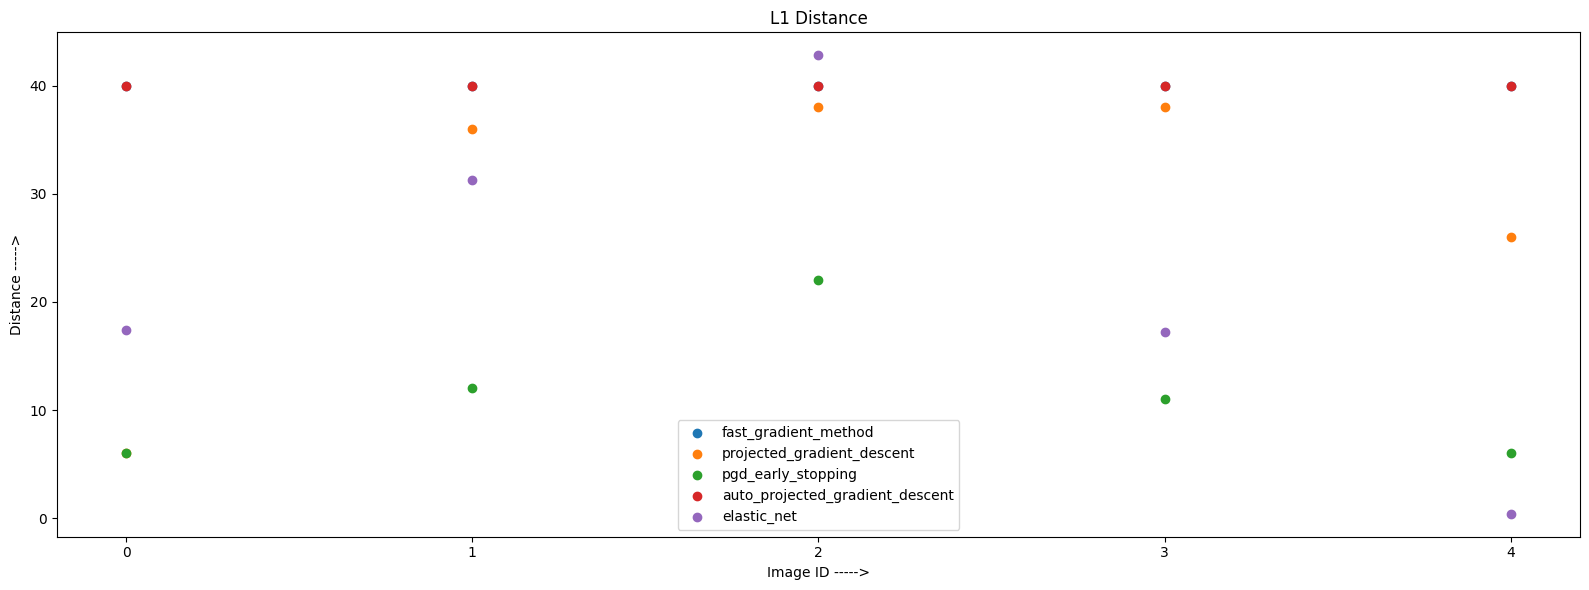

In [41]:
plt.figure(figsize=(16, 6))
for attack_type in attack_types:
  plt.scatter(list(range(len(xtest))), results_dict[attack_type]['adversarial_distance'], label=attack_type)
plt.xlabel('Image ID ----->')
plt.ylabel('Distance ----->')
plt.title(f'L{norm} Distance')
plt.legend()
plt.tight_layout()
plt.xticks(list(range(len(xtest))))
plt.show()

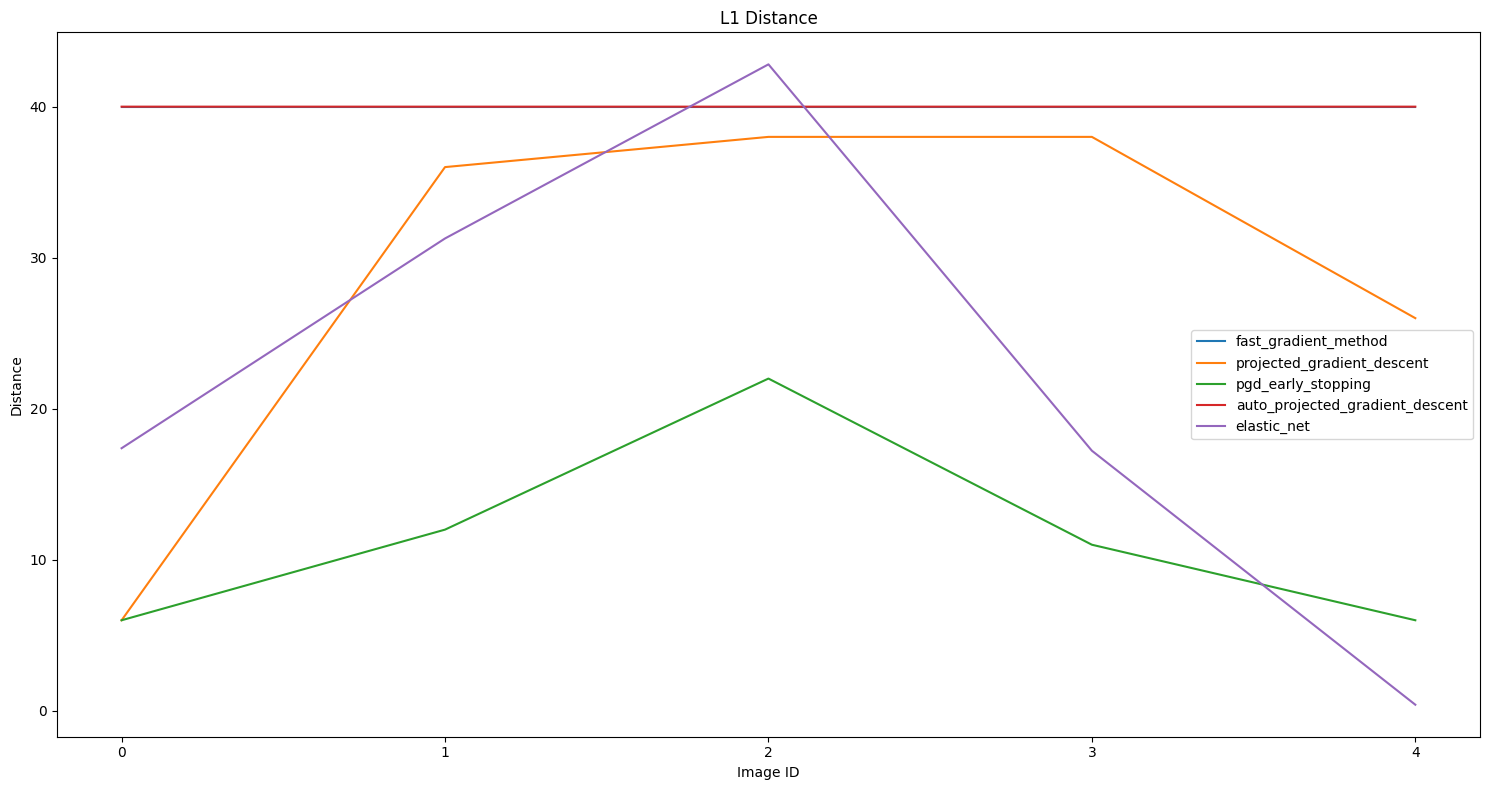

In [42]:
plt.figure(figsize=(15, 8))
for attack_type in attack_types:
  plt.plot(list(range(len(xtest))), results_dict[attack_type]['adversarial_distance'], label=attack_type)
plt.xlabel('Image ID')
plt.ylabel('Distance')
plt.title(f'L{norm} Distance')
plt.legend()
plt.tight_layout()
plt.xticks(list(range(len(xtest))))
plt.show()

# Runtime per image

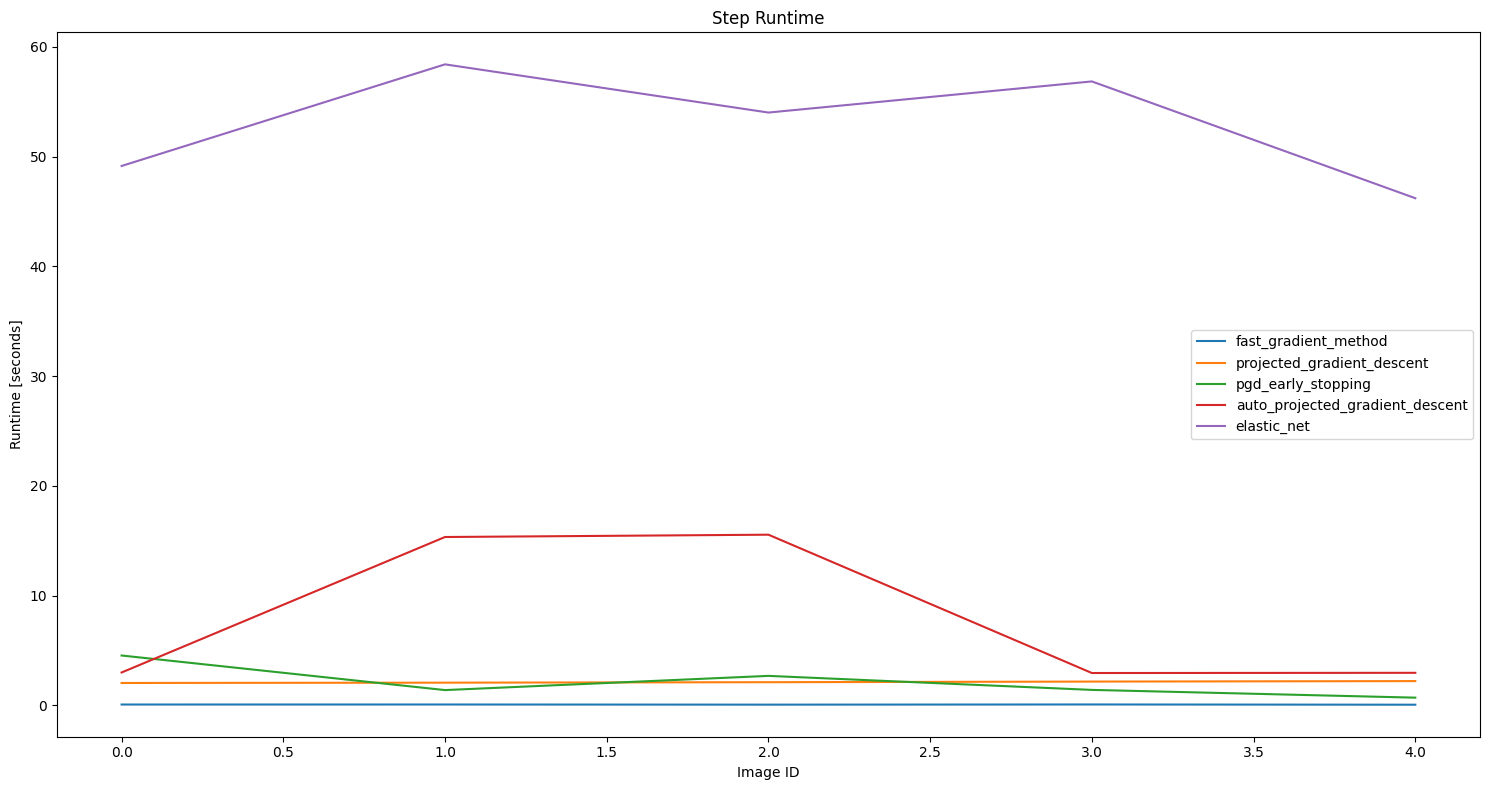

In [43]:
plt.figure(figsize=(15, 8))
for attack_type in attack_types:
  plt.plot(list(range(len(xtest))), results_dict[attack_type]['runtime'], label=attack_type)
plt.xlabel('Image ID')
plt.ylabel('Runtime [seconds]')
plt.title('Step Runtime')
plt.legend()
plt.tight_layout()
plt.show()

## Adversarial Accuracy

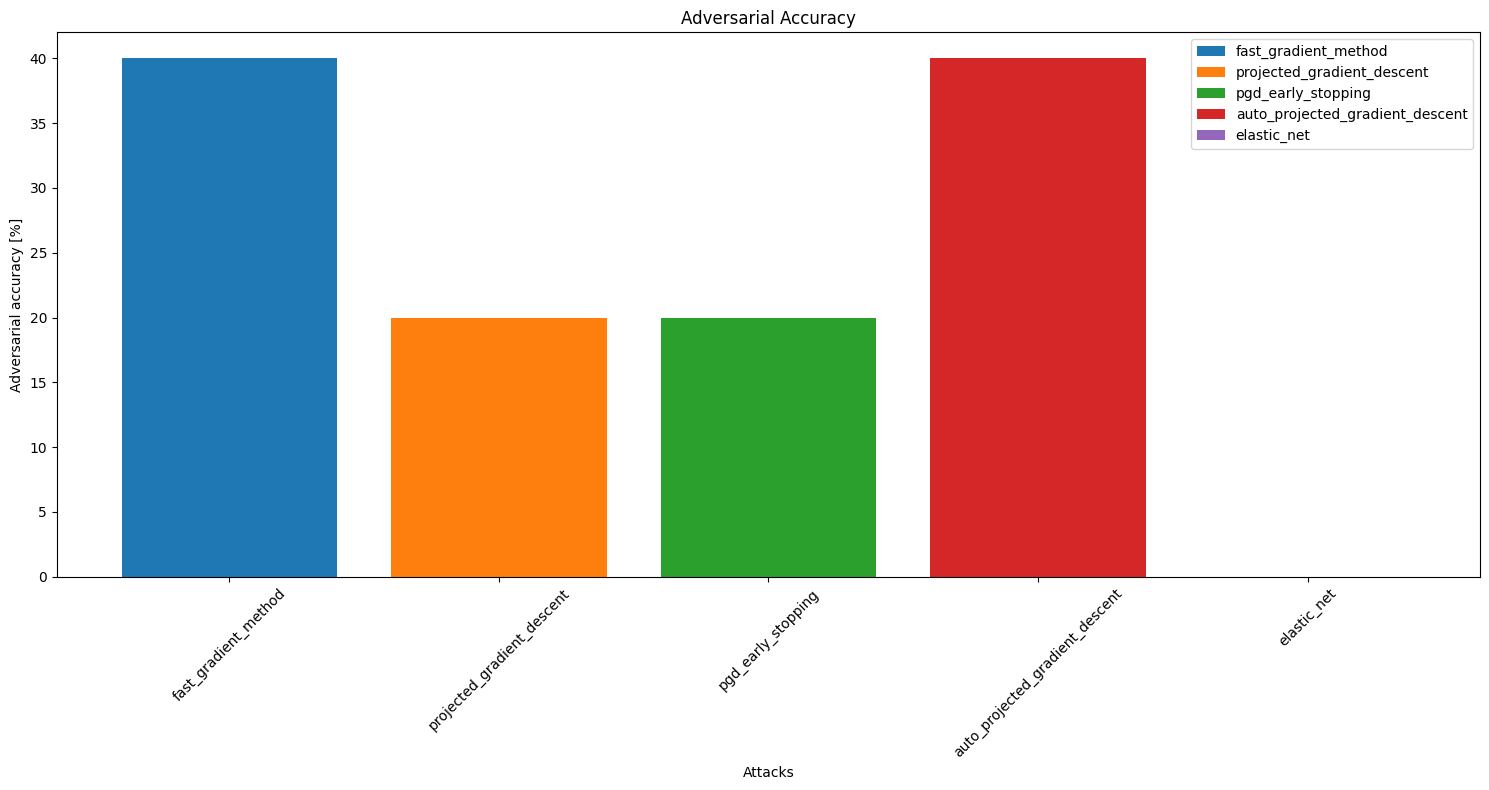

In [44]:
plt.figure(figsize=(15, 8))
for attack_type in attack_types:
  plt.bar(attack_type, results_dict[attack_type]['adversarial_accuracy'], label=attack_type)
plt.xlabel('Attacks')
plt.ylabel('Adversarial accuracy [%]')
plt.xticks(rotation=45)
plt.legend()
plt.title('Adversarial Accuracy')
plt.tight_layout()
plt.show()

## Total Runtime

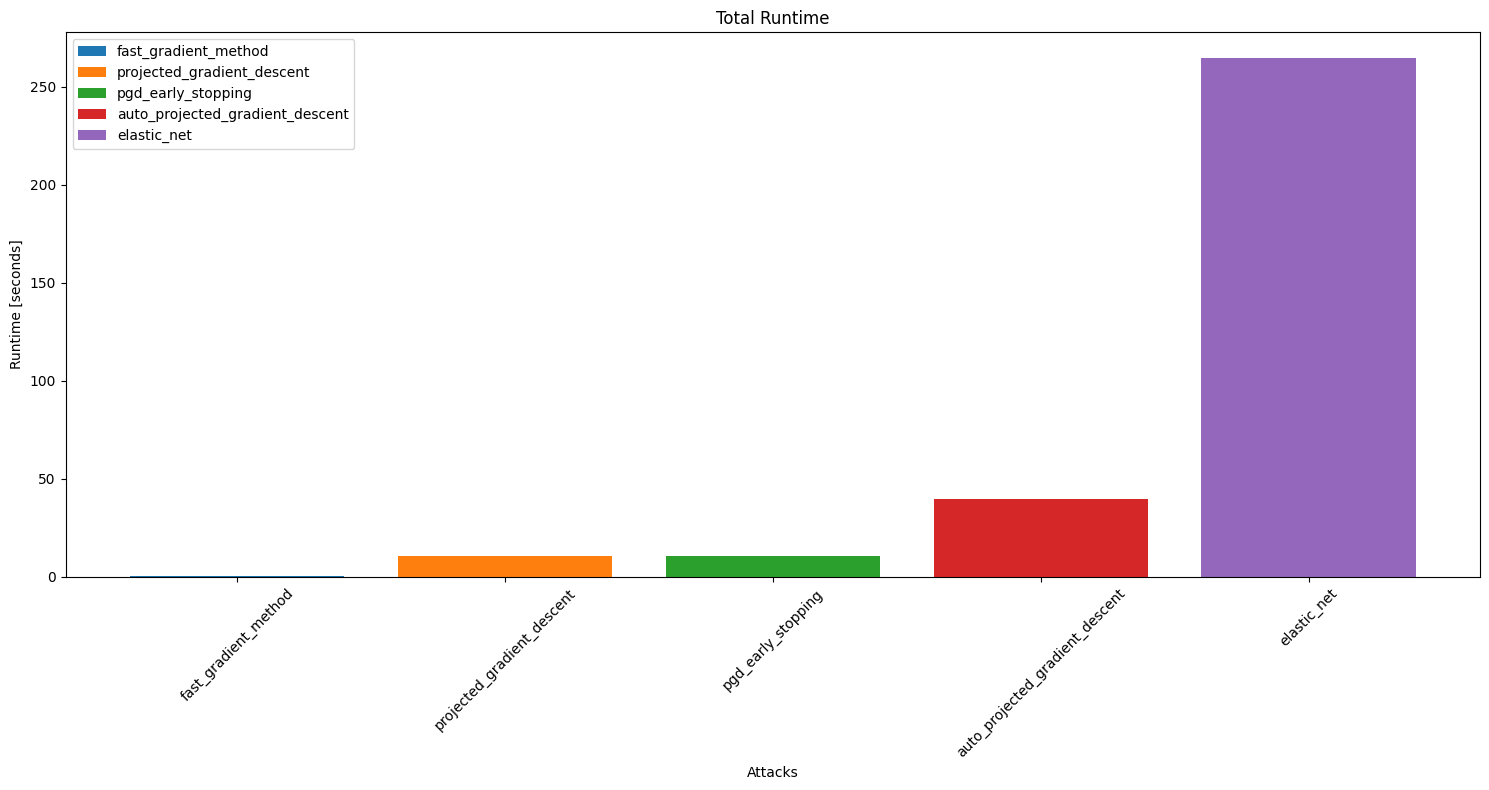

In [45]:
plt.figure(figsize=(15, 8))
for attack_type in attack_types:
  plt.bar(attack_type, sum(results_dict[attack_type]['runtime']), label=attack_type)
plt.xlabel('Attacks')
plt.xticks(rotation=45)
plt.ylabel('Runtime [seconds]')
plt.title('Total Runtime')
plt.legend()
plt.tight_layout()
plt.show()